In [150]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from datetime import timedelta
from tqdm import tqdm
from rtree.index import Index as RTreeIndex

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [151]:
def nearest_edges(rtree, geoms, X, Y, interpolate=None, return_dist=False):
    is_scalar = False
    if not (hasattr(X, "__iter__") and hasattr(Y, "__iter__")):
        # make coordinates arrays if user passed non-iterable values
        is_scalar = True
        X = np.array([X])
        Y = np.array([Y])

    if np.isnan(X).any() or np.isnan(Y).any():  # pragma: no cover
        raise ValueError("`X` and `Y` cannot contain nulls")

    # if no interpolation distance was provided
    if interpolate is None:
        # use r-tree to find possible nearest neighbors, one point at a time,
        # then minimize euclidean distance from point to the possible matches
        ne_dist = list()
        for xy in zip(X, Y):
            dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
            ne_dist.append((dists.idxmin(), dists.min()))
        ne, dist = zip(*ne_dist)

    # otherwise, if interpolation distance was provided
    else:
        # interpolate points along edges to index with k-d tree or ball tree
        uvk_xy = list()
        for uvk, geom in zip(geoms.index, geoms.values):
            uvk_xy.extend((uvk, xy) for xy in utils_geo.interpolate_points(geom, interpolate))
        labels, xy = zip(*uvk_xy)
        vertices = pd.DataFrame(xy, index=labels, columns=["x", "y"])

        if projection.is_projected(G.graph["crs"]):
            # if projected, use k-d tree for euclidean nearest-neighbor search
            if cKDTree is None:  # pragma: no cover
                raise ImportError("scipy must be installed to search a projected graph")
            dist, pos = cKDTree(vertices).query(np.array([X, Y]).T, k=1)
            ne = vertices.index[pos]

        else:
            # if unprojected, use ball tree for haversine nearest-neighbor search
            if BallTree is None:  # pragma: no cover
                raise ImportError("scikit-learn must be installed to search an unprojected graph")
            # haversine requires lat, lng coords in radians
            vertices_rad = np.deg2rad(vertices[["y", "x"]])
            points_rad = np.deg2rad(np.array([Y, X]).T)
            dist, pos = BallTree(vertices_rad, metric="haversine").query(points_rad, k=1)
            dist = dist[:, 0] * EARTH_RADIUS_M  # convert radians -> meters
            ne = vertices.index[pos[:, 0]]

    # convert results to correct types for return
    ne = list(ne)
    dist = list(dist)
    if is_scalar:
        ne = ne[0]
        dist = dist[0]

    if return_dist:
        return ne, dist
    else:
        return ne

In [152]:
def get_geoms(G):
    return ox.utils_graph.graph_to_gdfs(G, nodes=False)['geometry']

def get_rtree(G, geoms):
    # build the r-tree spatial index by position for subsequent iloc
    rtree = RTreeIndex()
    for pos, bounds in enumerate(geoms.bounds.values):
        rtree.insert(pos, bounds)
    return rtree
bk = ox.io.load_graphml('bk.graphml')
bk_geoms = get_geoms(bk)
bk_rtree = get_rtree(bk, bk_geoms)

def k_nearest_edges(rtree, geoms, x, y, k=3):
    # use r-tree to find possible nearest neighbors, one point at a time,
    # then minimize euclidean distance from point to the possible matches
    xy = (x, y)
    dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
    dists_df = pd.DataFrame([a[0][0:2] + (a[1],) for a in zip(dists.index, dists)], columns=['u', 'v', 'dist'])
    return dists_df.nsmallest(k, 'dist', keep='first').reset_index(drop=True)

In [390]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
ROUTE = 'b54'

In [391]:
b_times_df = pd.read_csv(f'{EXPORTS_DIR}/stop_times/{ROUTE}_weekday_stop_times.csv')
b_trajectories_df = pd.read_csv(f'{EXPORTS_DIR}/trajectories/{ROUTE}_all_trajectories.csv')
#b_trajectories_gdf = gpd.GeoDataFrame(b_trajectories_df, geometry=gpd.points_from_xy(b_trajectories_df['longitude'], b_trajectories_df['latitude']), crs=CRS_PLOT)

In [392]:
bus_ids = set(b_trajectories_df['bus_id'])
X = 1
Y = 0

In [393]:
def get_trajectories(b_gdf):
    trajectories = []
    curr_bus_id = None
    curr_x = None
    curr_trajectory = []
    LENGTH_THRESHOLD = 10
    trajectories_dict = {}
    
    for i in range(0, len(b_gdf)):
        row = b_gdf.iloc[i]
        lat = row['latitude']
        lon = row['longitude']
        time = row['datetime']
        bus_id = row['bus_id']

        if curr_x == None and curr_bus_id == None:
            curr_x = row['x']
            curr_bus_id = row['bus_id']
            if curr_x == X:
                curr_trajectory.append((lon, lat, time))
        elif row['bus_id'] == curr_bus_id:
            if row['x'] == curr_x:
                if row['x'] == X:
                    curr_trajectory.append((lon, lat, time))
            else:
                # Ignore accidental swap x=0, x=1
                if row['x'] == Y and i + 1 < len(b_gdf) and b_gdf.iloc[i + 1]['x'] == Y:
                    if len(curr_trajectory) > LENGTH_THRESHOLD:
                        if bus_id not in trajectories_dict:
                            trajectories_dict[bus_id] = []
                        trajectories_dict[bus_id].append(curr_trajectory)
                    curr_trajectory = []
                # Ignore accidental swap x=0, x=1
                if not (row['x'] == Y and i + 1 < len(b_gdf) and b_gdf.iloc[i + 1]['x'] == Y):
                    curr_x = row['x']
        else:
            if len(curr_trajectory) > LENGTH_THRESHOLD:
                if bus_id not in trajectories_dict:
                    trajectories_dict[bus_id] = []
                trajectories_dict[bus_id].append(curr_trajectory)
            curr_trajectory = []
            curr_bus_id = row['bus_id']
            curr_x = row['x']
            if curr_x == X:
                curr_trajectory.append((lon, lat, time))
    if len(curr_trajectory) > LENGTH_THRESHOLD:
        if bus_id not in trajectories_dict:
            trajectories_dict[bus_id] = []
        trajectories_dict[bus_id].append(curr_trajectory)
    return trajectories_dict

In [394]:
b_trajectories_dict = get_trajectories(b_trajectories_df)

In [395]:
# Collect continuous trajectories into ID-grouped dictionary.
#b_trajectories_dict = {}
#for bus_id in bus_ids:
#    df = b_trajectories_gdf[b_trajectories_gdf['bus_id'] == bus_id]
#    direction = df.iloc[0]['x']
#
#    trajectories = []
#    trajectory = []
#
#    for i in range(0, len(df)):
#        row = df.iloc[i]
#        if row['x'] != direction:
#            if direction == 0:
#                trajectories.append(trajectory)
#            trajectory = []
#            direction = row['x']
#
#        (x, y, t) = row[['longitude', 'latitude', 'datetime']]
#        trajectory.append((x, y, t))
#    if direction == 0 and len(trajectory) > 10:
#        display(tr)
#        trajectories.append(trajectory)
#    b_trajectories_dict[bus_id] = trajectories

In [396]:
route_graph = ox.io.load_graphml(f'{EXPORTS_DIR}/graphml/{ROUTE}.graphml')
rg_geoms = get_geoms(route_graph)
rg_rtree = get_rtree(route_graph, rg_geoms)

In [397]:
stops_gdf = gpd.read_file(f'{EXPORTS_DIR}/stops/{ROUTE}_stops.shp').iloc[0:]
stop_edges = nearest_edges(rg_rtree, rg_geoms, stops_gdf['stop_lon'], stops_gdf['stop_lat'])
stop_edge_nodes = [[e[0], e[1]] for e in stop_edges]
route_node_ids_df = pd.read_csv(f'{EXPORTS_DIR}/route_nodes/{ROUTE}_route_nodes.csv')
route_node_ids = route_node_ids_df.iloc[:, 0].tolist()

In [398]:
stops_gdf

,stop_id,FP_C1-Week,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_t,parent_sta,geometry
0,308472,01:07:00,JAY ST/MYRTLE PLZ,None,40.694503,-73.987123,None,None,0,None,POINT (-73.98712 40.69450)
1,307493,01:07:52,TILLARY ST/JAY ST,None,40.695976,-73.986768,None,None,0,None,POINT (-73.98677 40.69598)
2,308638,01:10:33,MYRTLE AV/FLEET PL,None,40.693501,-73.981498,None,None,0,None,POINT (-73.98150 40.69350)
3,306932,01:11:19,MYRTLE AV/ASHLAND PL,None,40.693431,-73.979334,None,None,0,None,POINT (-73.97933 40.69343)
4,306931,01:12:02,MYRTLE AV/ST EDWARDS ST,None,40.693356,-73.977372,None,None,0,None,POINT (-73.97737 40.69336)
5,306930,01:12:44,MYRTLE AV/N PORTLAND AV,None,40.693295,-73.975414,None,None,0,None,POINT (-73.97541 40.69329)
6,306929,01:13:48,MYRTLE AV/CARLTON AV,None,40.693205,-73.972448,None,None,0,None,POINT (-73.97245 40.69320)
7,306927,01:15:00,MYRTLE AV/VANDERBILT AV,None,40.693015,-73.969122,None,None,0,None,POINT (-73.96912 40.69302)
8,304390,01:15:14,MYRTLE AV/CLINTON AV,None,40.693104,-73.968360,None,None,0,None,POINT (-73.96836 40.69310)
9,304391,01:15:48,MYRTLE AV/WASHINGTON AV,None,40.693329,-73.966463,None,None,0,None,POINT (-73.96646 40.69333)


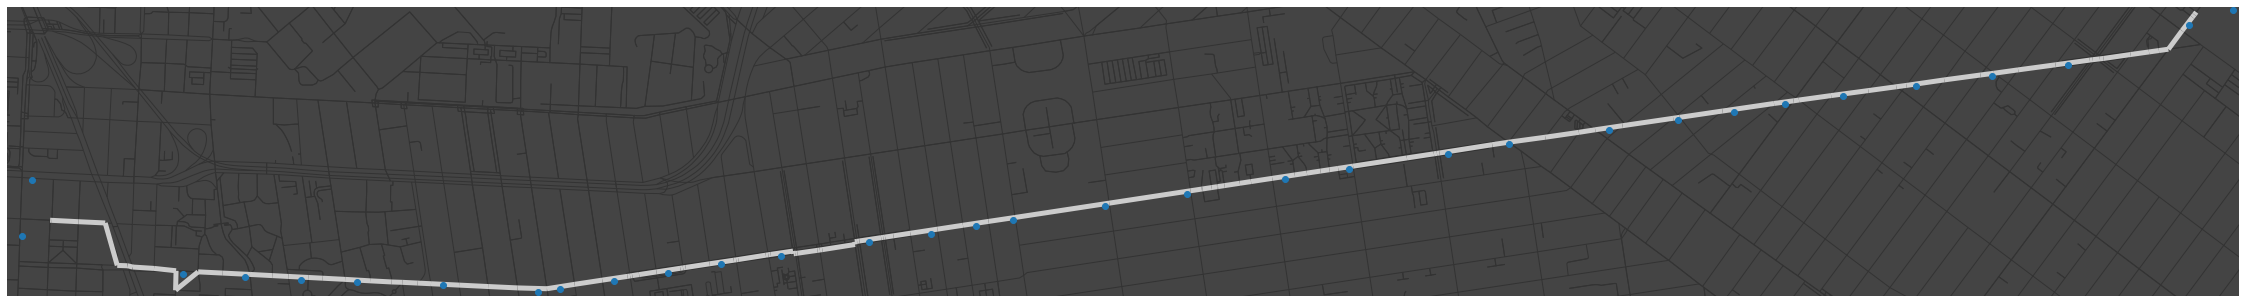

In [399]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#333')
ox.plot_graph(route_graph, ax=ax, bgcolor='#444', node_size=0, show=False, close=False, edge_color='#ccc', edge_linewidth=5)
stops_gdf.plot(ax=ax)
ax.set_facecolor('#444')

In [400]:
def dedup_consecutive(a):
    b = []
    last = None
    for i in range(0, len(a)):
        c = a[i]
        if c != last:
            last = c
            b.append(c)
    return b

In [401]:
#route = route_gdf.loc[0]

#route_graph_nodes = []
#for i in range(0, len(route_graph_edge_nodes) - 1):
#    edge0 = route_graph_edge_nodes[i]
#    edge1 = route_graph_edge_nodes[i + 1]
#    sp = ox.shortest_path(route_graph, edge0[1], edge1[0])
#    if sp is None:
#        raise Exception('oof')
#    nd = dedup_consecutive(edge0 + sp + [edge1[0]])
#    route_graph_nodes += nd
#
#route_graph_nodes = dedup_consecutive(route_graph_nodes)
#
#display(len(list(route_graph.nodes)))
#display(len(route_node_ids))
#for n in route_node_ids:
#    if n not in route_graph.nodes:
#        print(n)
#print(route_graph.nodes[4619812742])

In [402]:
def snap_to_edge(point, edge):
    p1 = edge[0]
    p2 = edge[1]
    x1 = float(p1[0])
    y1 = float(p1[1])
    x2 = float(p2[0])
    y2 = float(p2[1])
    x3 = point[0]
    y3 = point[1]
    
    m1 = (y2 - y1) / (x2 - x1)
    m3 = -1.0 / m1
    x = (m1 * x1 - m3 * x3 - y1 + y3) / (m1 - m3)
    y = m1 * (x - x1) + y1
    return [x, y]

In [403]:
class RouteNode:
    def __init__(self, i=0, id=0, node=None):
        self.i = i
        self.id = id
        self.node = node
        self.next_node = None
        self.x = node['x']
        self.y = node['y']
        self.t = 0
        self.st = 0
        
    def set_next_node(self, next_node):
        self.next_node = next_node
        self.distance_to_next =ox.distance.euclidean_dist_vec(self.y, self.x, next_node.y, next_node.x)

class Stop:
    def __init__(self, id=0, x=0, y=0, t=0):
        self.id = id
        self.x = x
        self.y = y
        self.t = t
        self.st = 0
        
        self.edge = nearest_edges(rg_rtree, rg_geoms, [self.x], [self.y])[0]
        
        self.prev_node_id = self.edge[0]
        self.next_node_id = self.edge[1]
        self.prev_node_index = route_node_ids.index(self.prev_node_id)
        try:
            self.next_node_index = route_node_ids.index(self.next_node_id, self.prev_node_index)
        except ValueError:
            self.next_node_index = route_node_ids.index(self.next_node_id)
        
        self.prev_node = route_graph.nodes[self.prev_node_id]
        self.next_node = route_graph.nodes[self.next_node_id]
        
        route_point = snap_to_edge([x, y], [[self.prev_node['x'], self.prev_node['y']], [self.next_node['x'], self.next_node['y']]])
        self.rx = route_point[0]
        self.ry = route_point[1]
        
        self.prev_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.prev_node['y'], self.prev_node['x'])
        self.next_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.next_node['y'], self.next_node['x'])
        
    def get_nearest_edge(self):
        edge = nearest_edges(rg_rtree, rg_geoms, route_gdf['stop_lon'], route_gdf['stop_lat'])
        
class TrajectoryPoint(Stop):
    def __init__(self, i=0, x=0, y=0, t=0):
        super().__init__(i, x, y, t)
        
        next_node_t = route_nodes[self.next_node_index].t
        prev_node_t = route_nodes[self.prev_node_index].t
        
        if next_node_t == 0:
            self.t_expected = None
        elif prev_node_t == 0:
            self.t_expected = None
        else:
            next_node_t -= datetime.timedelta(days=51)
            prev_node_t -= datetime.timedelta(days=51)
            self.t_expected = (self.prev_node_dist / (self.prev_node_dist + self.next_node_dist)) * (next_node_t - prev_node_t) + prev_node_t

In [404]:
route_nodes = []

for i in range(0, len(route_node_ids)):
    id = route_node_ids[i]
    route_nodes.append(RouteNode(i, id, route_graph.nodes[id]))
    
for i in range(0, len(route_node_ids) - 1):
    route_nodes[i].set_next_node(route_nodes[i + 1])

In [405]:
stops = []
stop_dict = {}
for i in range(0, len(stops_gdf)):
    row = stops_gdf.iloc[i]
    stop = Stop(id=int(row['stop_id']), x=row['stop_lon'], y=row['stop_lat'], t=0)#row['departure_'])
    stops.append(stop)
    stop_dict[stop.id] = stop

In [406]:
def calculate_route_node_expected_times(stops):
    for route_node in route_nodes:
        route_node.t = 0
        
    for k in range(0, len(stops) - 1):
        stop = stops[k] 
        stop.next_node_index
        next_stop = stops[k + 1]
        next_stop.prev_node_index

        total_dist = stop.next_node_dist
        for i in range(stop.next_node_index, next_stop.prev_node_index + 1):
            total_dist += route_nodes[i].distance_to_next
        total_dist += next_stop.prev_node_dist
        t0 = stop.t
        t1 = next_stop.t

        for i in range(stop.next_node_index, next_stop.prev_node_index + 1):
            node_dist = 0
            for j in range(i, next_stop.prev_node_index + 1):
                node_dist += route_nodes[j].distance_to_next
            node_dist += next_stop.prev_node_dist

            ratio = (total_dist - node_dist) / total_dist
            route_nodes[i].t = (t1 - t0) * ratio + t0

In [407]:
def calculate_route_node_actual_times(trajectory_points):
    # Calculate the actual time at each route node based on the trajectory times.
    for route_node in route_nodes:
        route_node.st = 0
        
    for k in range(0, len(trajectory_points) - 1):
        trajectory_point = trajectory_points[k] 
        trajectory_point.next_node_index
        next_trajectory_point = trajectory_points[k + 1]
        next_trajectory_point.prev_node_index

        total_dist = trajectory_point.next_node_dist
        for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
            total_dist += route_nodes[i].distance_to_next
        total_dist += next_trajectory_point.prev_node_dist
        t0 = trajectory_point.t
        t1 = next_trajectory_point.t

        for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
            node_dist = 0
            for j in range(i, next_trajectory_point.prev_node_index + 1):
                node_dist += route_nodes[j].distance_to_next
            node_dist += next_trajectory_point.prev_node_dist

            ratio = (total_dist - node_dist) / total_dist
            route_nodes[i].st = (t1 - t0) * ratio + t0

In [408]:
def calculate_stop_actual_times(trajectory_points):
    # Calculate the actual time at each stop based on the trajectory times.
    for stop in stops:
        stop.st = 0
    for k in range(0, len(stops) - 1):
        stop = stops[k]
        stop_prev_node = route_nodes[stop.prev_node_index]
        stop_next_node = route_nodes[stop.next_node_index]
        if stop_prev_node.st != 0 and stop_next_node.st != 0:
            ratio = stop.prev_node_dist / (stop.prev_node_dist + stop.next_node_dist)
            t0 = stop_prev_node.st
            t1 = stop_next_node.st
            stop.st = (t1 - t0) * ratio + t0

In [409]:
def plot(trajectory_points):
    fig, ax = plt.subplots(figsize=(40, 30))
    ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=10, node_color='black', show=False, close=False)

    X = [route_graph.nodes[n]['x'] for n in route_node_ids]
    Y = [route_graph.nodes[n]['y'] for n in route_node_ids]
    ax.scatter(X, Y, color='black')
    
    for i in range(0, len(route_nodes)):
        x = X[i]
        y = Y[i]
        k = 1 if i % 2 == 0 else -4
        route_node = route_nodes[i]
        if route_node.st != None and route_node.st != 0:
            ax.annotate(route_node.st.strftime('%H:%M'), (x, y),
                       xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='black')

    X = [t.rx for t in stops]
    Y = [t.ry for t in stops]
    ax.scatter(X, Y, color='red')

    for i in range(0, len(stops)):
        x = X[i]
        y = Y[i]
        k = 1 if i % 2 == 0 else -4
        stop = stops[i]
        if stop.st != None and stop.st != 0:
            ax.annotate(stop.st.strftime('%H:%M'), (x, y),
                       xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='red')

    X = [t.rx for t in trajectory_points]
    Y = [t.ry for t in trajectory_points]
    ax.scatter(X, Y, color='blue')

    for i in range(0, len(trajectory_points)):
        x = X[i]
        y = Y[i]
        k = 1 if i % 2 == 0 else -4
        tp = trajectory_points[i]
        if tp.t != 0:
            ax.annotate(tp.t.strftime('%H:%M'), (x, y),
                       xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='blue')

    plt.show()

In [410]:
stop_times_df = pd.read_csv(f'{EXPORTS_DIR}/stop_times/{ROUTE}_weekday_stop_times.csv')
stop_times_df

,trip_id,308472,307493,308638,306932,306931,306930,306929,306927,304390,...,304406,304407,304408,304409,304410,304411,304412,304413,308596,901258
0,FP_C1-Weekday-SDon-006700_B54_401,01:07:00,01:07:52,01:10:33,01:11:19,01:12:02,01:12:44,01:13:48,01:15:00,01:15:14,...,01:25:47,01:26:19,01:26:46,01:27:10,01:27:37,01:28:11,01:28:47,01:29:22,01:30:24,01:31:00
1,FP_C1-Weekday-SDon-013200_B54_401,02:12:00,02:12:52,02:15:33,02:16:19,02:17:02,02:17:44,02:18:48,02:20:00,02:20:14,...,02:30:47,02:31:19,02:31:46,02:32:10,02:32:37,02:33:11,02:33:47,02:34:22,02:35:24,02:36:00
2,FP_C1-Weekday-SDon-019700_B54_401,03:17:00,03:17:52,03:20:33,03:21:19,03:22:02,03:22:44,03:23:48,03:25:00,03:25:14,...,03:35:47,03:36:19,03:36:46,03:37:10,03:37:37,03:38:11,03:38:47,03:39:22,03:40:24,03:41:00
3,FP_C1-Weekday-SDon-026200_B54_401,04:22:00,04:22:52,04:25:33,04:26:19,04:27:02,04:27:44,04:28:48,04:30:00,04:30:14,...,04:40:47,04:41:19,04:41:46,04:42:10,04:42:37,04:43:11,04:43:47,04:44:22,04:45:24,04:46:00
4,FP_C1-Weekday-SDon-029600_B54_402,04:56:00,04:56:52,04:59:33,05:00:19,05:01:02,05:01:44,05:02:48,05:04:00,05:04:16,...,05:19:03,05:19:46,05:20:21,05:20:53,05:21:29,05:22:15,05:23:02,05:23:50,05:25:12,05:26:00
5,FP_C1-Weekday-SDon-032600_B54_403,05:26:00,05:26:59,05:29:59,05:30:52,05:31:39,05:32:27,05:33:39,05:35:00,05:35:16,...,05:50:03,05:50:46,05:51:21,05:51:53,05:52:29,05:53:15,05:54:02,05:54:50,05:56:12,05:57:00
6,FP_C1-Weekday-SDon-035600_B54_404,05:56:00,05:56:59,05:59:59,06:00:52,06:01:39,06:02:27,06:03:39,06:05:00,06:05:24,...,06:23:03,06:23:46,06:24:21,06:24:53,06:25:29,06:26:15,06:27:02,06:27:50,06:29:12,06:30:00
7,FP_C1-Weekday-038500_B54_402,06:25:00,06:26:12,06:29:52,06:30:57,06:31:55,06:32:53,06:34:21,06:36:00,06:36:24,...,06:57:34,06:58:39,06:59:32,07:00:19,07:01:13,07:02:22,07:03:33,07:04:44,07:06:48,07:08:00
8,FP_C1-Weekday-040500_B54_405,06:45:00,06:46:12,06:49:52,06:50:57,06:51:55,06:52:53,06:54:21,06:56:00,06:56:24,...,07:17:34,07:18:39,07:19:32,07:20:19,07:21:13,07:22:22,07:23:33,07:24:44,07:26:48,07:28:00
9,FP_C1-Weekday-042000_B54_403,07:00:00,07:01:12,07:04:52,07:05:57,07:06:55,07:07:53,07:09:21,07:11:00,07:11:24,...,07:32:34,07:33:39,07:34:32,07:35:19,07:36:13,07:37:22,07:38:33,07:39:44,07:41:48,07:43:00


In [411]:
stops_gdf

,stop_id,FP_C1-Week,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_t,parent_sta,geometry
0,308472,01:07:00,JAY ST/MYRTLE PLZ,None,40.694503,-73.987123,None,None,0,None,POINT (-73.98712 40.69450)
1,307493,01:07:52,TILLARY ST/JAY ST,None,40.695976,-73.986768,None,None,0,None,POINT (-73.98677 40.69598)
2,308638,01:10:33,MYRTLE AV/FLEET PL,None,40.693501,-73.981498,None,None,0,None,POINT (-73.98150 40.69350)
3,306932,01:11:19,MYRTLE AV/ASHLAND PL,None,40.693431,-73.979334,None,None,0,None,POINT (-73.97933 40.69343)
4,306931,01:12:02,MYRTLE AV/ST EDWARDS ST,None,40.693356,-73.977372,None,None,0,None,POINT (-73.97737 40.69336)
5,306930,01:12:44,MYRTLE AV/N PORTLAND AV,None,40.693295,-73.975414,None,None,0,None,POINT (-73.97541 40.69329)
6,306929,01:13:48,MYRTLE AV/CARLTON AV,None,40.693205,-73.972448,None,None,0,None,POINT (-73.97245 40.69320)
7,306927,01:15:00,MYRTLE AV/VANDERBILT AV,None,40.693015,-73.969122,None,None,0,None,POINT (-73.96912 40.69302)
8,304390,01:15:14,MYRTLE AV/CLINTON AV,None,40.693104,-73.968360,None,None,0,None,POINT (-73.96836 40.69310)
9,304391,01:15:48,MYRTLE AV/WASHINGTON AV,None,40.693329,-73.966463,None,None,0,None,POINT (-73.96646 40.69333)


In [412]:
def dt_string_to_seconds(dt_string):
    if dt_string is None:
        return np.nan
    hours = int(dt_string[0:2])
    minutes = int(dt_string[3:5])
    seconds = int(dt_string[6:8])
    return hours * 24 * 60 + minutes * 60 + seconds

def calculate_time_diff(matched_df):
    return matched_df.iloc[:, 3:-3].applymap(dt_string_to_seconds).diff(1).iloc[1, :]

In [413]:
tx = list(b_trajectories_dict.values())[0][0]
tps = [
    TrajectoryPoint(i=0,
                    x=x,
                    y=y,
                    t=datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S'))
    for (x, y, t) in tx
]

In [414]:
calculate_route_node_actual_times(tps)
calculate_stop_actual_times(tps)

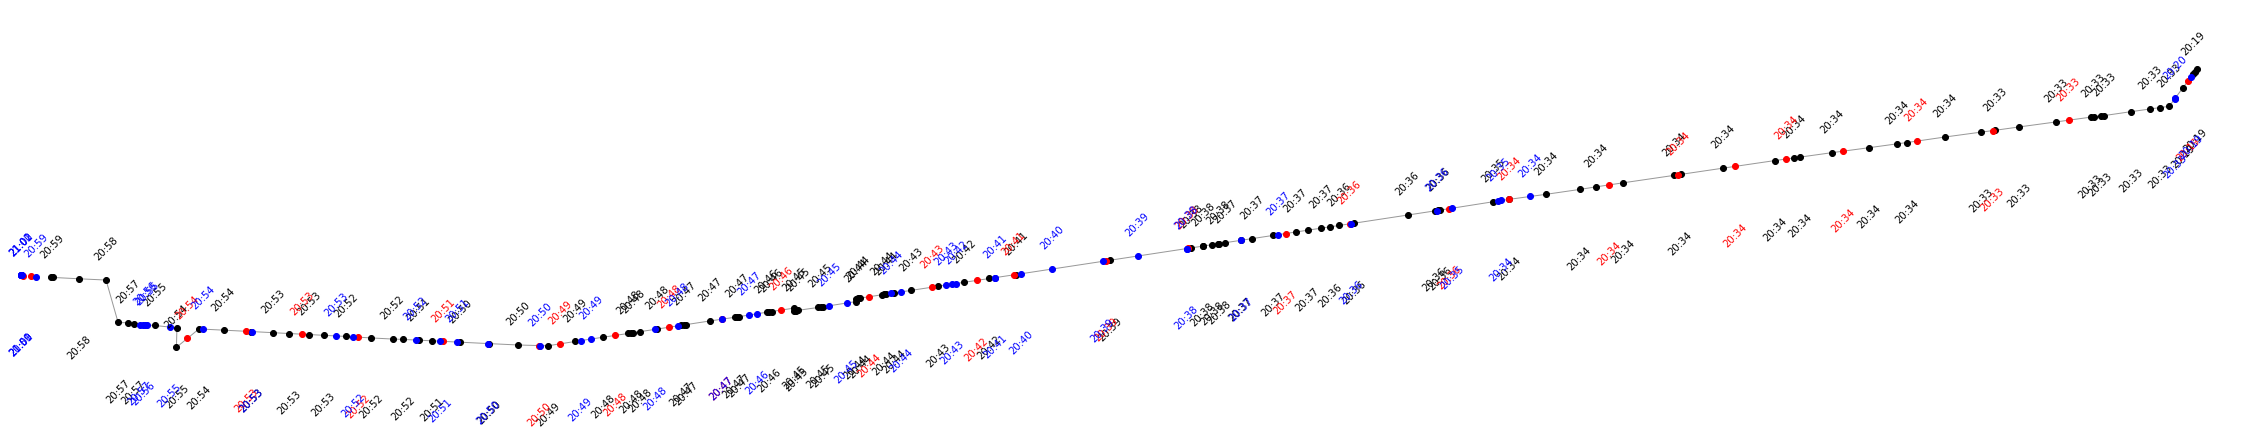

In [415]:
plot(tps)

In [416]:
def to_datetime(dt):
    if dt is None:
        return None
    if type(dt) != str:
        return None
    if dt[0:2] == '24':
        dt2 = pd.to_datetime('00' + dt[2:], format='%H:%M:%S') + timedelta(days=1)
    else:
        dt2 = pd.to_datetime(dt, format='%H:%M:%S')
    return dt2

def find_closest_schedule(start_index=1, end_index=-3):
    columns = list(stops_gdf['stop_id'])
    route_actual_times = pd.DataFrame(
        {
            column: [stop.st.strftime('%H:%M:%S') if stop.st != 0 else None]
            for (column, stop) in zip(columns, stops)
        },
        columns=columns)
    
    start_col = route_actual_times.columns[start_index]
    actual_start_time = to_datetime(route_actual_times[start_col].iloc[0])
    
    if actual_start_time == None:
        return None

    end_col = route_actual_times.columns[end_index]
    actual_end_time = to_datetime(route_actual_times[end_col].iloc[0])
    if actual_end_time == None:
        return None
    
    stop_diffs_df = stop_times_df.copy()[['trip_id', str(start_col)]]
    stop_diffs_df[str(start_col)] = stop_diffs_df[str(start_col)].apply(to_datetime)
    stop_diffs_df['diff'] = stop_diffs_df[str(start_col)] - actual_start_time
    threshold = 5
    matching_df = stop_diffs_df[
        (stop_diffs_df['diff'] < timedelta(minutes=5)) &
        (stop_diffs_df['diff'] > timedelta(minutes=-20))]
    matching_trips = list(matching_df['trip_id'])
    
    matching_dfs = [stop_times_df[stop_times_df['trip_id'] == t] for t in matching_trips]

    return matching_dfs

In [422]:
START_INDEX = 7 
END_INDEX = -7

diff_rows = []
ij = 0
for bus_id, trajectories in tqdm(list(b_trajectories_dict.items())):
    if ij > 10 and len(diff_rows) == 0:
        print('fail')
        break
    ij += 1
    for trajectory in trajectories:
        if len(trajectory) < 10:
            continue
        trajectory_points = [
            TrajectoryPoint(i=0,
                            x=x,
                            y=y,
                            t=datetime.datetime.strptime(
                                t, '%Y-%m-%d %H:%M:%S'))
            for (x, y, t) in trajectory
        ]
        calculate_route_node_actual_times(trajectory_points)
        calculate_stop_actual_times(trajectory_points)
        matched_dfs = find_closest_schedule(START_INDEX, END_INDEX)
        if matched_dfs is not None:
            min_diff_df = None
            min_diff_sum = 2**16
            min_trip_id = None
            for matched_df in matched_dfs:
                expected_stops = []
                for i in range(START_INDEX, len(matched_df.columns) + END_INDEX):
                    matching_stop = stop_dict[int(matched_df.columns[i])]
                    x = matching_stop.x
                    y = matching_stop.y
                    matched_df.iloc[0, i] = to_datetime(matched_df.iloc[0, i])
                    t = pd.to_datetime(matched_df.iloc[0, i])
                    expected_stop = Stop(id=matching_stop.id, x=x, y=y, t=t)
                    expected_stops.append(expected_stop)

                try:
                    calculate_route_node_expected_times(expected_stops)
                except TypeError:
                    print(f'Error at {bus_id}')
                    continue

                df_dict = {n.id: n.t for n in route_nodes if n.t != 0 and n.st != 0}
                expected_df = pd.DataFrame([df_dict], columns=df_dict.keys())
                df_dict = {
                    n.id: n.st for n in route_nodes if n.t != 0 and n.st != 0
                }
                actual_df = pd.DataFrame([df_dict], columns=df_dict.keys())

                expected_df = expected_df.applymap(lambda x: x.strftime('%H:%M:%S'))
                actual_df = actual_df.applymap(lambda x: x.strftime('%H:%M:%S'))
                diff_df = calculate_time_diff(pd.concat([expected_df, actual_df]))
                diff_sum = diff_df.abs().sum()
                trip_id = matched_df.iloc[0, 0]
                if diff_sum < min_diff_sum:
                    diff_sum = min_diff_sum
                    min_diff_df = diff_df
                    min_trip_id = trip_id
            if min_diff_df is not None and len(min_diff_df) > 0:
                diff_rows.append([min_trip_id, min_diff_df])
            #break

 21%|██        | 11/52 [00:34<02:09,  3.15s/it]

fail


In [423]:
diff_df = pd.DataFrame([x[1] for x in diff_rows])
diff_df.insert(0, 'trip_id', 'h')
diff_df['trip_id'] = [x[0] for x in diff_rows]
diff_df.to_csv(f'{EXPORTS_DIR}/diffs/{ROUTE}_diff.csv', index=False)
display(diff_df)

,trip_id


In [424]:
diff_avg_df = diff_df.median()
diff_avg_df = diff_avg_df.apply(lambda x: min(x, 600))
diff_avg_df = diff_avg_df.apply(lambda x: max(x, -600))

In [425]:
def create_route_subgraph(node_ids):
    graph = nx.MultiDiGraph()
    for node_id in node_ids:
        node = bk.nodes[node_id]
        graph.add_node(node_id, **node)
    for i in range(0, len(node_ids) - 1):
        graph.add_edge(node_ids[i], node_ids[i + 1])
    graph.graph['crs'] = CRS_PLOT
    return graph

route_subgraph = create_route_subgraph([n for n in route_node_ids if n in set(diff_avg_df.index)])

for edge in route_subgraph.edges:
    route_subgraph.add_edge(edge[0], edge[1], edge[2], weight=0)

for i in range(0, len(route_nodes) - 1):
    route_node = route_nodes[i]
    next_node = route_nodes[i + 1]
    if route_node.id not in diff_avg_df.index:
        continue
    if next_node.id not in diff_avg_df.index:
        continue
    time_delta = diff_avg_df.loc[route_node.id]
    route_subgraph.add_edge(route_node.id, next_node.id, 0, weight=time_delta)

ValueError: There are no attribute values.

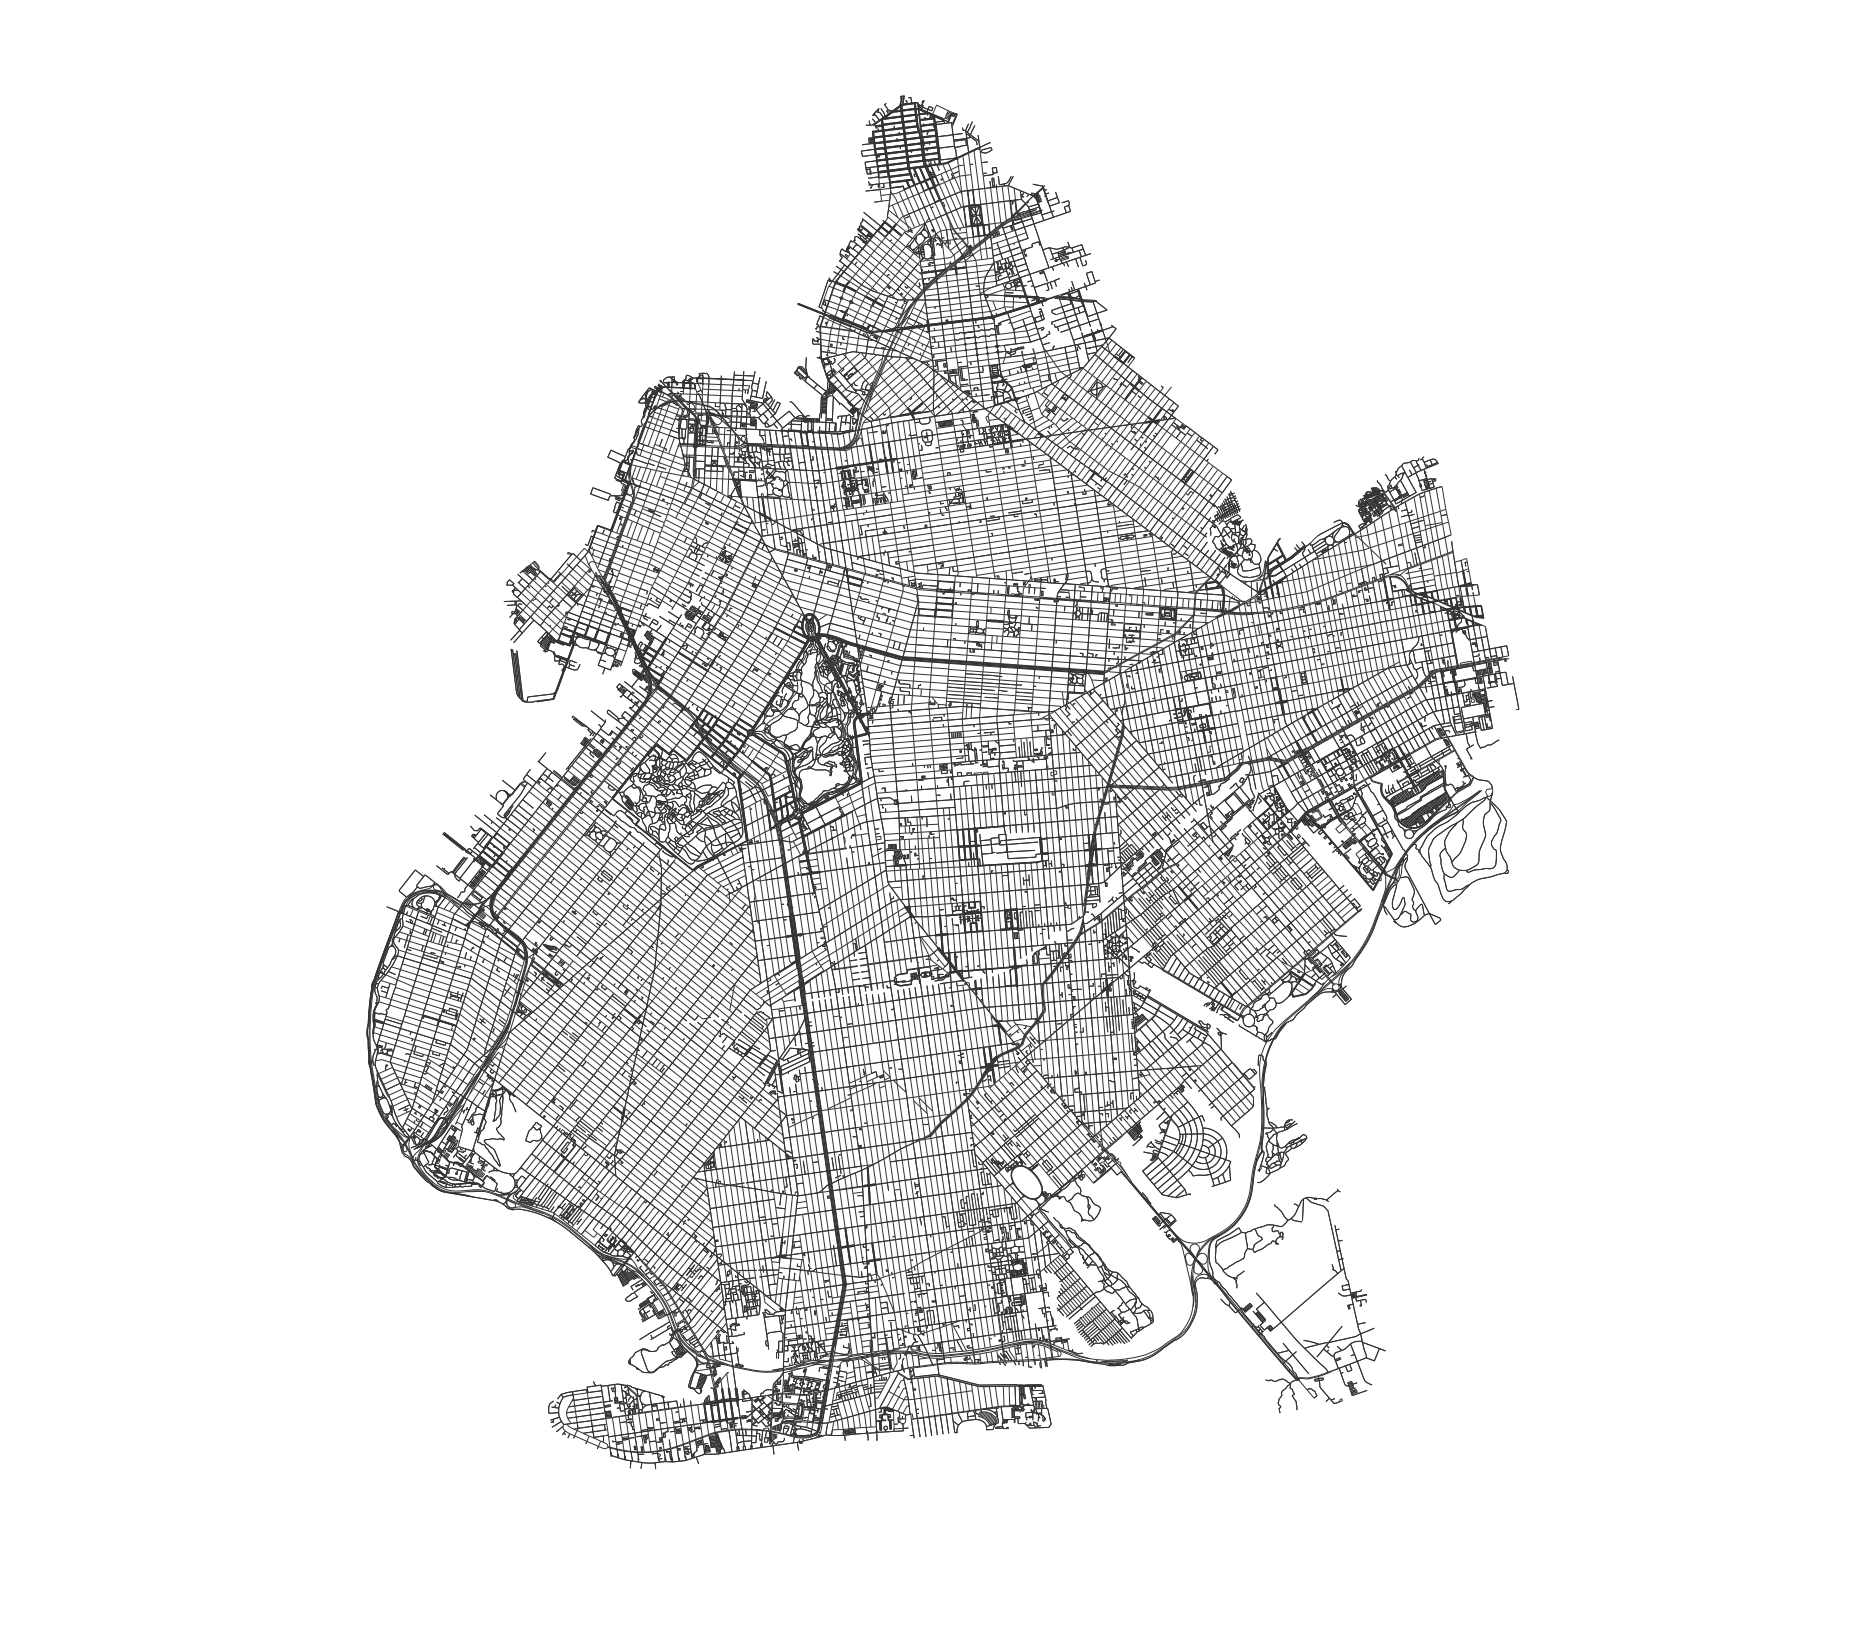

In [426]:
bbox=(40.75, 40.55, -73.80, -74.10)
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, bbox=bbox, show=False, close=False, edge_color='#333')

edge_colors = ox.plot.get_edge_colors_by_attr(route_subgraph, attr='weight', cmap='coolwarm')
ox.plot_graph(route_subgraph, ax=ax, bgcolor='#444', node_size=0, bbox=bbox, show=False, close=False, edge_color=edge_colors, edge_linewidth=5)
ax.set_facecolor('#444')
plt.show()